<a href="https://colab.research.google.com/github/nola-ada/sample/blob/main/JLeagueSpectatorLgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter('ignore')

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#japanaize_matplotlibがimportできなかったため追記
#標準ライブラリにないライブラリは%pipやcondaでインストールする
%pip install japanize_matplotlib
import japanize_matplotlib
%matplotlib inline

#lightGBM関係のライブラリのimport
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=a885f4b4bf1b4479135cee8cf44b449ec78da36253d34c779ed2085450f70d64
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


In [ ]:
#ディレクトリの移動(colab独特の方法)
%cd "/content/drive/MyDrive/NeuroDive/IT講座/GoogleColab/コンペ/Jリーグの観客動員数予測/data"

#csvファイルを読み込んでDataFrame名を付けている
train = pd.read_csv('train.csv')
train_add = pd.read_csv('train_add.csv')
test = pd.read_csv('test.csv')
add_2014 = pd.read_csv('2014_add.csv')
stadium = pd.read_csv('stadium.csv')
condition = pd.read_csv('condition.csv')
condition_add = pd.read_csv('condition_add.csv')

/content/drive/MyDrive/NeuroDive/IT講座/GoogleColab/コンペ/Jリーグの観客動員数予測/data


In [ ]:
#読み込んだDataFrameの確認
print('train shape: ', train.shape)
print('train_add shape: ', train_add.shape)
print('test shape: ',test.shape)
print('condition shape: ', condition.shape)
print('condition_add shape: ', condition_add.shape)
print('stadium shape:', stadium.shape)

train shape:  (1721, 11)
train_add shape:  (232, 11)
test shape:  (313, 10)
condition shape:  (2034, 31)
condition_add shape:  (270, 31)
stadium shape: (59, 3)


In [ ]:
#読み込んだDataFrameの確認
print(train.dtypes)
print(train_add.dtypes)
print(test.dtypes)
print(condition.dtypes)
print(condition_add.dtypes)
print(stadium.dtypes)

id          int64
y           int64
year        int64
stage      object
match      object
gameday    object
time       object
home       object
away       object
stadium    object
tv         object
dtype: object
id          int64
y           int64
year        int64
stage      object
match      object
gameday    object
time       object
home       object
away       object
stadium    object
tv         object
dtype: object
id          int64
year        int64
stage      object
match      object
gameday    object
time       object
home       object
away       object
stadium    object
tv         object
dtype: object
id               int64
home_score       int64
away_score       int64
weather         object
temperature    float64
humidity        object
referee         object
home_team       object
home_01         object
home_02         object
home_03         object
home_04         object
home_05         object
home_06         object
home_07         object
home_08         object
home_09       

In [ ]:
# train, train_addを確認
display(train.head(), train_add.head())


,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌


,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,14003,19010,2012,Ｊ１,第２節第１日,03/17(土),14:04,鹿島アントラーズ,川崎フロンターレ,県立カシマサッカースタジアム,スカパー／ｅ２／スカパー光／ＮＨＫ水戸
1,14020,15072,2012,Ｊ１,第３節第２日,03/25(日),19:03,ガンバ大阪,ジュビロ磐田,万博記念競技場,スカパー／ｅ２／スカパー光
2,14023,25743,2012,Ｊ１,第４節第１日,03/31(土),15:03,浦和レッズ,川崎フロンターレ,埼玉スタジアム２００２,スカパー／ｅ２／スカパー光／テレ玉
3,14076,24183,2012,Ｊ１,第１０節第１日,05/06(日),13:03,横浜Ｆ・マリノス,コンサドーレ札幌,日産スタジアム,スカパー／ｅ２／スカパー光
4,14081,20512,2012,Ｊ１,第１０節第１日,05/06(日),17:03,名古屋グランパス,川崎フロンターレ,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／名古屋テレビ（録）


In [ ]:
# condition, condition_addを確認
display(condition.head(), condition_add.head())

,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ
1,13995,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,...,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀
2,13996,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人
3,13997,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,...,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也
4,13998,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,...,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一


,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,14003,0,1,雨,13.3,86%,西村 雄一,鹿島アントラーズ,曽ヶ端 準,新井場 徹,...,實藤 友紀,ジェシ,森下 俊,小宮山 尊信,中村 憲剛,柴崎 晃誠,田坂 祐介,山瀬 功治,レナト,小松 塁
1,14020,1,2,曇,4.6,56%,家本 政明,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,駒野 友一,チョ ビョングク,藤田 義明,金沢 浄,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一
2,14023,1,1,雨,10.0,65%,家本 政明,浦和レッズ,加藤 順大,坪井 慶介,...,田中 裕介,ジェシ,森下 俊,小宮山 尊信,中村 憲剛,柴崎 晃誠,田坂 祐介,山瀬 功治,レナト,小松 塁
3,14076,2,1,晴,27.9,47%,今村 義朗,横浜Ｆ・マリノス,飯倉 大樹,小林 祐三,...,日高 拓磨,ジェイド ノース,櫛引 一紀,岩沼 俊介,河合 竜二,宮澤 裕樹,古田 寛幸,近藤 祐介,高木 純平,前田 俊介
4,14081,2,3,晴,19.0,48%,吉田 寿光,名古屋グランパス,楢﨑 正剛,石櫃 洋祐,...,田中 裕介,井川 祐輔,森下 俊,登里 享平,稲本 潤一,中村 憲剛,大島 僚太,田坂 祐介,楠神 順平,矢島 卓郎


In [ ]:
# stadiumを確認
stadium.head()

,name,address,capa
0,名古屋市瑞穂陸上競技場,愛知県名古屋市瑞穂区山下通5-1,20000
1,豊田スタジアム,愛知県豊田市千石町7-2,40000
2,フクダ電子アリーナ,千葉県千葉市中央区川崎町1-20,18500
3,日立柏サッカー場,千葉県柏市日立台1-2-50,15349
4,ニンジニアスタジアム,愛媛県松山市上野町乙46,15576


In [ ]:
# testを確認
test.head()

,id,year,stage,match,gameday,time,home,away,stadium,tv
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス
1,15823,2014,Ｊ１,第１８節第１日,08/02(土),18:34,鹿島アントラーズ,サンフレッチェ広島,県立カシマサッカースタジアム,スカパー！／スカパー！プレミアムサービス
2,15824,2014,Ｊ１,第１８節第１日,08/02(土),19:04,浦和レッズ,ヴィッセル神戸,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉
3,15825,2014,Ｊ１,第１８節第１日,08/02(土),19:03,柏レイソル,川崎フロンターレ,日立柏サッカー場,スカパー！／スカパー！プレミアムサービス
4,15827,2014,Ｊ１,第１８節第１日,08/02(土),19:03,アルビレックス新潟,セレッソ大阪,デンカビッグスワンスタジアム,スカパー！／スカパー！プレミアムサービス


In [ ]:
# trainとtrain_add、conditionとcondition_addをそれぞれ結合
full_train = pd.concat([train, train_add], axis=0)
full_condition = pd.concat([condition, condition_add], axis=0)

In [ ]:
# 結合前と後で形に異常がないか確認(列の値が2つのDataFrameの合計になっているか確認)
print('train concat')
print('before: ', train.shape, train_add.shape)
print('after: ', full_train.shape)
print('condition concat')
print('before: ', condition.shape, condition_add.shape)
print('after: ', full_condition.shape)
full_condition.head()

train concat
before:  (1721, 11) (232, 11)
after:  (1953, 11)
condition concat
before:  (2034, 31) (270, 31)
after:  (2304, 31)


,id,home_score,away_score,weather,temperature,humidity,referee,home_team,home_01,home_02,...,away_02,away_03,away_04,away_05,away_06,away_07,away_08,away_09,away_10,away_11
0,13994,1,0,雨,3.8,66%,木村 博之,ベガルタ仙台,林 卓人,菅井 直樹,...,新井場 徹,岩政 大樹,中田 浩二,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ
1,13995,1,0,屋内,12.4,43%,西村 雄一,名古屋グランパス,楢﨑 正剛,田中 隼磨,...,吉田 豊,岩下 敬輔,カルフィン ヨン ア ピン,李 記帝,村松 大輔,河井 陽介,枝村 匠馬,高木 俊幸,アレックス,大前 元紀
2,13996,2,3,晴一時雨,11.3,41%,高山 啓義,ガンバ大阪,藤ヶ谷 陽介,加地 亮,...,近藤 岳登,北本 久仁衛,伊野波 雅彦,相馬 崇人,三原 雅俊,田中 英雄,野沢 拓也,橋本 英郎,森岡 亮太,大久保 嘉人
3,13997,1,0,曇一時雨のち晴,11.4,52%,松尾 一,サンフレッチェ広島,西川 周作,森脇 良太,...,濱田 水輝,阿部 勇樹,槙野 智章,平川 忠亮,鈴木 啓太,山田 直輝,梅崎 司,柏木 陽介,原口 元気,田中 達也
4,13998,0,0,屋内,22.5,32%,廣瀬 格,コンサドーレ札幌,李 昊乗,高木 純平,...,駒野 友一,チョ ビョングク,藤田 義明,山本 脩斗,小林 裕紀,山本 康裕,山田 大記,松浦 拓弥,菅沼 実,前田 遼一


In [ ]:
full_train.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌


In [ ]:
stadium.head()

,name,address,capa
0,名古屋市瑞穂陸上競技場,愛知県名古屋市瑞穂区山下通5-1,20000
1,豊田スタジアム,愛知県豊田市千石町7-2,40000
2,フクダ電子アリーナ,千葉県千葉市中央区川崎町1-20,18500
3,日立柏サッカー場,千葉県柏市日立台1-2-50,15349
4,ニンジニアスタジアム,愛媛県松山市上野町乙46,15576


In [ ]:
# 結合する特徴量を選択
stadium = stadium.rename(columns={'name': 'stadium'})
stadium = stadium[['stadium', 'capa']]
full_condition = full_condition[['id' ,'weather' ,'temperature' ,'humidity']]
stadium.head()

,stadium,capa
0,名古屋市瑞穂陸上競技場,20000
1,豊田スタジアム,40000
2,フクダ電子アリーナ,18500
3,日立柏サッカー場,15349
4,ニンジニアスタジアム,15576


In [ ]:
# 結合
#左結合（LEFT JOIN）: how='left'
#leftを基準に結合。rightにキーが存在しない行も残る。左外部結合とも呼ばれる。
full_train = pd.merge(full_train, stadium, on='stadium',  how='left')
full_train = pd.merge(full_train, full_condition, on='id',  how='left')
full_test = pd.merge(test, stadium, on='stadium',  how='left')
full_test = pd.merge(full_test, full_condition, on='id',  how='left')

In [ ]:
#結合後の確認
display(full_train.head(), full_test.head())
print('full_train shape: ', full_train.shape)
print('full_test shape: ', full_test.shape)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,19694,雨,3.8,66%
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,40000,屋内,12.4,43%
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,21000,晴一時雨,11.3,41%
3,13997,29603,2012,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島,50000,曇一時雨のち晴,11.4,52%
4,13998,25353,2012,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌,39232,屋内,22.5,32%


,id,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,19694,晴,27.4,70%
1,15823,2014,Ｊ１,第１８節第１日,08/02(土),18:34,鹿島アントラーズ,サンフレッチェ広島,県立カシマサッカースタジアム,スカパー！／スカパー！プレミアムサービス,40728,晴,30.8,65%
2,15824,2014,Ｊ１,第１８節第１日,08/02(土),19:04,浦和レッズ,ヴィッセル神戸,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉,63700,晴,31.7,58%
3,15825,2014,Ｊ１,第１８節第１日,08/02(土),19:03,柏レイソル,川崎フロンターレ,日立柏サッカー場,スカパー！／スカパー！プレミアムサービス,15349,晴,29.3,76%
4,15827,2014,Ｊ１,第１８節第１日,08/02(土),19:03,アルビレックス新潟,セレッソ大阪,デンカビッグスワンスタジアム,スカパー！／スカパー！プレミアムサービス,42300,晴,30.4,68%


full_train shape:  (1953, 15)
full_test shape:  (313, 14)


In [ ]:
# 欠損値などの確認
full_train.isnull().sum()

,0
id,0
y,0
year,0
stage,0
match,0
gameday,0
time,0
home,0
away,0
stadium,0


In [ ]:
full_test.isnull().sum()

,0
id,0
year,0
stage,0
match,0
gameday,0
time,0
home,0
away,0
stadium,0
tv,0


In [ ]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1953 non-null   int64  
 1   y            1953 non-null   int64  
 2   year         1953 non-null   int64  
 3   stage        1953 non-null   object 
 4   match        1953 non-null   object 
 5   gameday      1953 non-null   object 
 6   time         1953 non-null   object 
 7   home         1953 non-null   object 
 8   away         1953 non-null   object 
 9   stadium      1953 non-null   object 
 10  tv           1953 non-null   object 
 11  capa         1953 non-null   int64  
 12  weather      1953 non-null   object 
 13  temperature  1953 non-null   float64
 14  humidity     1953 non-null   object 
dtypes: float64(1), int64(4), object(10)
memory usage: 229.0+ KB


In [ ]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           313 non-null    int64  
 1   year         313 non-null    int64  
 2   stage        313 non-null    object 
 3   match        313 non-null    object 
 4   gameday      313 non-null    object 
 5   time         313 non-null    object 
 6   home         313 non-null    object 
 7   away         313 non-null    object 
 8   stadium      313 non-null    object 
 9   tv           313 non-null    object 
 10  capa         313 non-null    int64  
 11  weather      313 non-null    object 
 12  temperature  313 non-null    float64
 13  humidity     313 non-null    object 
dtypes: float64(1), int64(3), object(10)
memory usage: 34.4+ KB


In [ ]:
# object型のデータを確認
full_train.select_dtypes(include=object).head()

,stage,match,gameday,time,home,away,stadium,tv,weather,humidity
0,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,雨,66%
1,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,屋内,43%
2,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,晴一時雨,41%
3,Ｊ１,第１節第１日,03/10(土),14:06,サンフレッチェ広島,浦和レッズ,エディオンスタジアム広島,スカパー／ｅ２／スカパー光／ＮＨＫ広島,曇一時雨のち晴,52%
4,Ｊ１,第１節第１日,03/10(土),14:04,コンサドーレ札幌,ジュビロ磐田,札幌ドーム,スカパー／ｅ２／スカパー光（スカイ・Ａ ｓｐｏｒｔｓ＋）／ＮＨＫ札幌,屋内,32%


In [ ]:
#full_train[['match','section']]

In [ ]:
# 第○節の数字をsectionとして取り出す
full_train['section'] = full_train['match'].apply(lambda x: x.split('節')[0][1:]).astype(int)
full_test['section'] = full_test['match'].apply(lambda x: x.split('節')[0][1:]).astype(int)
# gamedayから月と曜日を取り出す
full_train['month'] = full_train['gameday'].apply(lambda x: x[:2]).astype(int)
full_train['weekday'] = full_train['gameday'].apply(lambda x: x[6])
full_test['month'] = full_test['gameday'].apply(lambda x: x[:2]).astype(int)
full_test['weekday'] = full_test['gameday'].apply(lambda x: x[6])
# timeから時間を取り出す
full_train['hour'] = full_train['time'].apply(lambda x: x.split(':')[0]).astype(int)
full_test['hour'] = full_test['time'].apply(lambda x: x.split(':')[0]).astype(int)
# tvからサービスの数をカウント
full_train['num_tv'] = full_train['tv'].apply(lambda x: len(x.split('／')))
full_test['num_tv'] = full_test['tv'].apply(lambda x: len(x.split('／')))
# humidityから％を切り取り数値データに変換
full_train['humidity'] = full_train['humidity'].apply(lambda x: x.rstrip('%')).astype(int)
full_test['humidity'] = full_test['humidity'].apply(lambda x: x.rstrip('%')).astype(int)
# 完成したデータを確認
display(full_train.head(3), full_test.head(3))

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity,section,month,weekday,hour,num_tv
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,19694,雨,3.8,66,1,3,土,14,4
1,13995,24316,2012,Ｊ１,第１節第１日,03/10(土),14:04,名古屋グランパス,清水エスパルス,豊田スタジアム,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ ４）／ＮＨＫ名古屋,40000,屋内,12.4,43,1,3,土,14,4
2,13996,17066,2012,Ｊ１,第１節第１日,03/10(土),14:04,ガンバ大阪,ヴィッセル神戸,万博記念競技場,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）／ＮＨＫ大阪,21000,晴一時雨,11.3,41,1,3,土,14,4


,id,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity,section,month,weekday,hour,num_tv
0,15822,2014,Ｊ１,第１８節第１日,08/02(土),19:04,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー！／スカパー！プレミアムサービス,19694,晴,27.4,70,18,8,土,19,2
1,15823,2014,Ｊ１,第１８節第１日,08/02(土),18:34,鹿島アントラーズ,サンフレッチェ広島,県立カシマサッカースタジアム,スカパー！／スカパー！プレミアムサービス,40728,晴,30.8,65,18,8,土,18,2
2,15824,2014,Ｊ１,第１８節第１日,08/02(土),19:04,浦和レッズ,ヴィッセル神戸,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／ＮＨＫ ＢＳ１／テレ玉,63700,晴,31.7,58,18,8,土,19,4


In [ ]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1953 non-null   int64  
 1   y            1953 non-null   int64  
 2   year         1953 non-null   int64  
 3   stage        1953 non-null   object 
 4   match        1953 non-null   object 
 5   gameday      1953 non-null   object 
 6   time         1953 non-null   object 
 7   home         1953 non-null   object 
 8   away         1953 non-null   object 
 9   stadium      1953 non-null   object 
 10  tv           1953 non-null   object 
 11  capa         1953 non-null   int64  
 12  weather      1953 non-null   object 
 13  temperature  1953 non-null   float64
 14  humidity     1953 non-null   int64  
 15  section      1953 non-null   int64  
 16  month        1953 non-null   int64  
 17  weekday      1953 non-null   object 
 18  hour         1953 non-null   int64  
 19  num_tv

In [ ]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           313 non-null    int64  
 1   year         313 non-null    int64  
 2   stage        313 non-null    object 
 3   match        313 non-null    object 
 4   gameday      313 non-null    object 
 5   time         313 non-null    object 
 6   home         313 non-null    object 
 7   away         313 non-null    object 
 8   stadium      313 non-null    object 
 9   tv           313 non-null    object 
 10  capa         313 non-null    int64  
 11  weather      313 non-null    object 
 12  temperature  313 non-null    float64
 13  humidity     313 non-null    int64  
 14  section      313 non-null    int64  
 15  month        313 non-null    int64  
 16  weekday      313 non-null    object 
 17  hour         313 non-null    int64  
 18  num_tv       313 non-null    int64  
dtypes: float

In [ ]:
# 数値データの統計値を算出
full_train.describe()

,id,y,year,capa,temperature,humidity,section,month,hour,num_tv
count,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000
mean,15049.442396,10629.558116,2012.820276,25688.549411,20.438914,60.220174,18.050691,6.316948,16.310804,2.656938
std,646.260483,8102.315189,0.758124,14016.934408,6.438737,19.953138,11.153364,2.500493,2.310252,0.715085
min,13994.000000,0.000000,2012.000000,3560.000000,1.400000,12.000000,1.000000,3.000000,12.000000,1.000000
25%,14482.000000,4687.000000,2012.000000,15589.000000,15.800000,44.000000,9.000000,4.000000,14.000000,2.000000
50%,15044.000000,8594.000000,2013.000000,20246.000000,21.400000,63.000000,17.000000,6.000000,16.000000,3.000000
75%,15532.000000,13471.000000,2013.000000,30132.000000,25.600000,77.000000,27.000000,8.000000,19.000000,3.000000
max,16238.000000,62632.000000,2014.000000,72327.000000,34.200000,99.000000,42.000000,12.000000,20.000000,5.000000


In [ ]:
# 無観客試合のデータを確認
full_train[full_train['y']==0]


,id,y,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity,section,month,weekday,hour,num_tv
1385,15699,0,2014,Ｊ１,第４節第１日,03/23(日),15:04,浦和レッズ,清水エスパルス,埼玉スタジアム２００２,スカパー！／スカパー！プレミアムサービス／テレ玉,63700,晴,16.2,23,4,3,日,15,3


In [ ]:
# 無観客試合のデータを削除
full_train.drop(index=1385, inplace=True)
full_train[full_train['y']==0]


,id,y,year,stage,match,gameday,time,home,away,stadium,tv,capa,weather,temperature,humidity,section,month,weekday,hour,num_tv


In [ ]:
full_train.corr(numeric_only=True)['y']

,y
id,-0.176920
y,1.000000
year,0.003211
capa,0.688290
temperature,-0.028072
humidity,-0.100557
section,-0.044138
month,0.105861
hour,0.029106
num_tv,0.142387


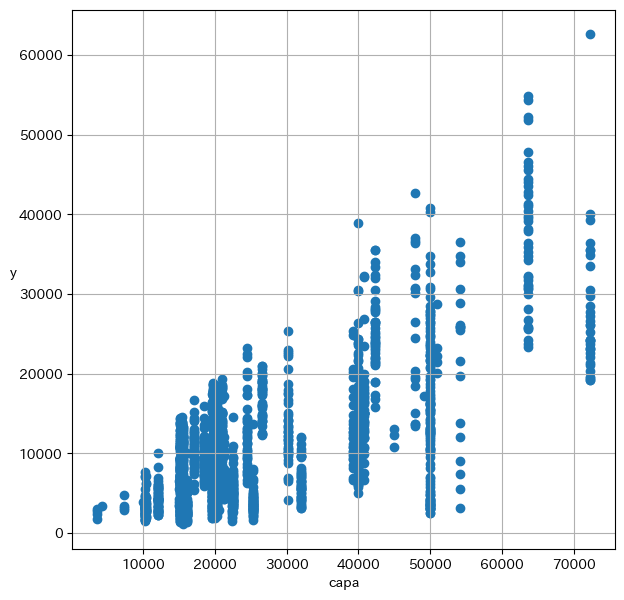

In [ ]:
#スタジアムのキャパと観客数の関係
plt.figure(figsize=(7, 7))
plt.scatter(x=full_train['capa'], y=full_train['y'])
plt.grid()
plt.xlabel('capa')
plt.ylabel('y', rotation=0)
#plt.title('yとcapaの相関係数:{}',format(round(full_train.corr()['y']['capa'], 4)))
plt.show()

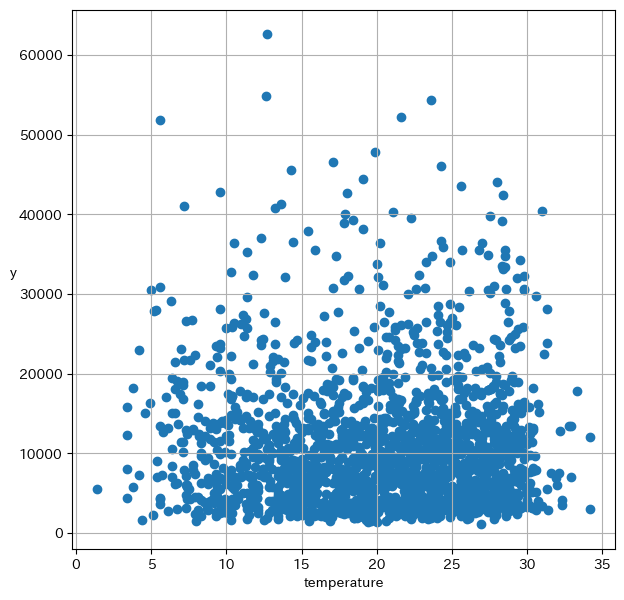

In [ ]:
#気温と客の関係
plt.figure(figsize=(7, 7))
plt.scatter(x=full_train['temperature'], y=full_train['y'])
plt.grid()
plt.xlabel('temperature')
plt.ylabel('y', rotation=0)
#plt.title('yとtemperatureの相関係数:{}'.format(round(full_train.corr()['y']['temperature'], 4)))
plt.show()

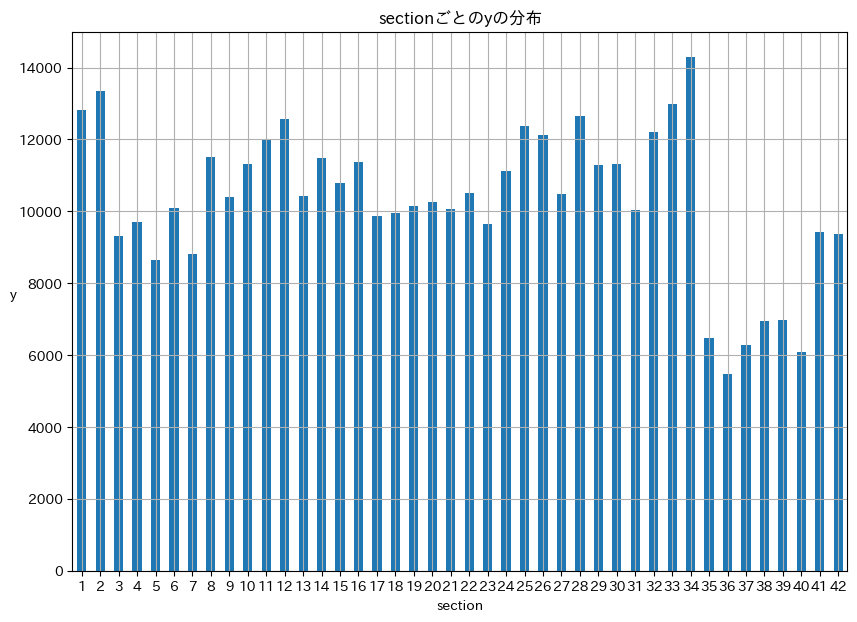

In [ ]:
#sectionと観客数の関係
plt.figure(figsize=(10, 7))
full_train.groupby('section')['y'].mean().plot.bar()
plt.grid()
plt.xlabel('section')
plt.xticks(rotation=0)
plt.ylabel('y', rotation=0)
plt.title('sectionごとのyの分布')
plt.show()

In [ ]:
#sectionを一部切り取った場合の平均観客数
print('section35~40の6section分の試合数 : ', len(full_train.query('35<=section<=40')), '平均観客数 : ', full_train.query('35<=section<=40')['y'].mean())
print('section29~34の6section分の試合数 : ', len(full_train.query('29<=section<=34')), '平均観客数 : ', full_train.query('29<=section<=34')['y'].mean())


section35~40の6section分の試合数 :  132 平均観客数 :  6373.037878787879
section29~34の6section分の試合数 :  240 平均観客数 :  12023.55


In [ ]:

full_train.query('35<=section<=40').stage.value_counts()

,count
stage,
Ｊ２,132


In [ ]:
full_train.query('29<=section<=34').stage.value_counts()

,count
stage,
Ｊ２,132
Ｊ１,108


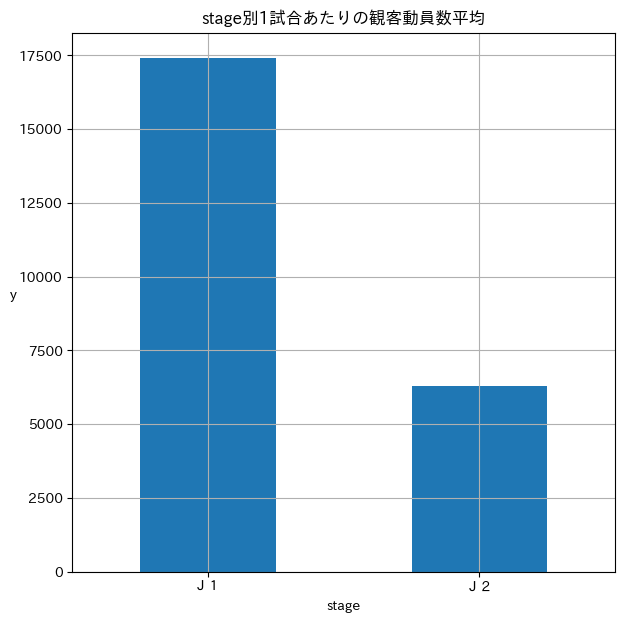

In [ ]:
#J1とJ2の観客動員数の違い
plt.figure(figsize=(7, 7))
full_train.groupby('stage')['y'].mean().plot.bar()
plt.grid()
plt.xticks(rotation=0)
plt.ylabel('y', rotation=0)
plt.title('stage別1試合あたりの観客動員数平均')
plt.show()

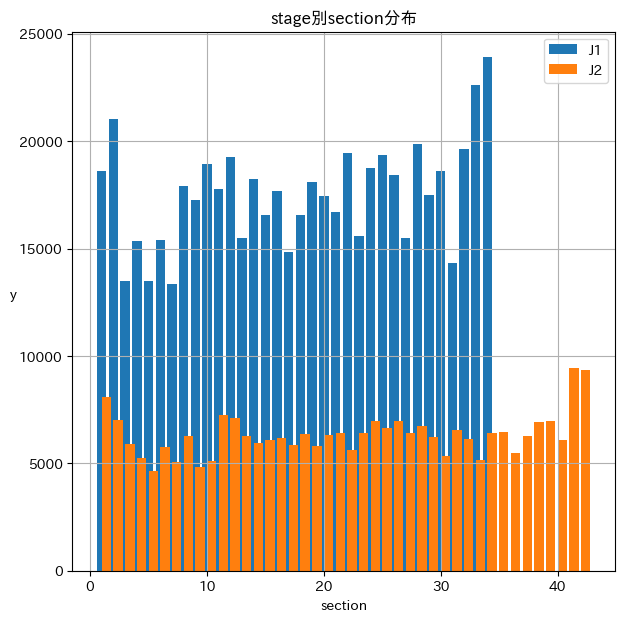

In [ ]:
#J1J2別にしたときのsectionごとの観客動員数
plt.figure(figsize=(7, 7))
J1_group = full_train[full_train['stage'] == 'Ｊ１'].groupby('section')['y'].mean()
J2_group = full_train[full_train['stage'] == 'Ｊ２'].groupby('section')['y'].mean()
plt.bar(J1_group.index, J1_group, label='J1')
plt.bar(J2_group.index, J2_group, label='J2', align='edge')
plt.legend()
plt.grid()
plt.xlabel('section')
plt.ylabel('y', rotation=0)
plt.title('stage別section分布')
plt.show()

In [ ]:
# 学習に使用する特徴量の選択
use_columns = ['capa', 'section', 'stage','month', 'hour', 'num_tv']
y = full_train['y']
train = full_train[use_columns]
test = full_test[use_columns]
#カテゴリ変数のダミー変数化
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)
# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split(train, y, test_size = 0.2)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

trains = lgb.Dataset(x_train, y_train)
valids = lgb.Dataset(x_valid, y_valid)

# パラメータの設定
parms = {
    'task': 'train', #トレーニング用
    'boosting': 'gbdt', #勾配ブースティング決定木
    'objective': 'regression_l1', #目的：MAエラーを目的とした回帰
    'metric': 'mae', #評価指標：MAE
    'num_iterations': 1000, #1000回学習
    'verbose': -1 #学習情報を非表示
}

(1561, 6) (391, 6) (1561,) (391,)


In [ ]:
# AIモデル学習
model = lgb.train(parms,
                 #訓練データ
                 train_set=trains,
                 # 評価データ
                 valid_sets=valids,
                 callbacks=[lgb.early_stopping(stopping_rounds=100)])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[55]	valid_0's l1: 2167.87


In [ ]:
# 結果の予測
y_pred = model.predict(x_valid)

from sklearn.metrics import mean_absolute_error as MAE
print(f"Mean Absolute Error: {MAE(y_valid, y_pred)}")

Mean Absolute Error: 2167.8701284207687


In [ ]:
# sample_submitの読み込み
submit = pd.read_csv('sample_submit.csv', header=None)

# 予測結果の適用
y_pred = model.predict(test)
submit[1] = y_pred
submit.to_csv('/content/drive/MyDrive/NeuroDive/IT講座/GoogleColab/コンペ/Jリーグの観客動員数予測/submission_first3.csv', header=None, index=False)
submit.head()

,0,1
0,15822,14350.066590
1,15823,15015.111589
2,15824,31769.885900
3,15825,10851.126967
4,15827,24270.497764
